# Exercício 4 

# Análise de Sentimento de Manchetes com Meta Prompting

## Objetivo
Coletar manchetes de um portal de notícias e realizar análise de sentimento usando Gemini Pro com técnica de Meta Prompting

In [7]:
# Importações necessárias
import os
import requests
from bs4 import BeautifulSoup
import json
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
import google.generativeai as genai

# Carregar variáveis de ambiente
load_dotenv()

c:\infnet_ultimo_semestre\TP3_Eng_de_Prompt_Parte_2_local\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [8]:
# Configurar a API do Google
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

# Configurar o modelo Gemini Pro
model = genai.GenerativeModel('gemini-pro')

In [9]:
# Função para raspar manchetes do G1
def scrape_headlines():
    url = 'https://g1.globo.com/'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Seletor CSS para manchetes principais
    headlines = soup.select('.feed-post-link')
    
    return [headline.text.strip() for headline in headlines[:10]]

In [10]:
# Coletar manchetes
headlines = scrape_headlines()
print("Manchetes coletadas:")
for h in headlines:
    print(f"- {h}")

Manchetes coletadas:
- Chanceler do Uruguai diz que há consenso sobre acordo Mercosul-UE
- Tarcísio diz que mudou de ideia e defende câmera na farda da PM
- Câmera de PM mostra abordagem que terminou com idosa agredida
- PM que jogou homem de ponte é preso após prestar depoimento
- Mega-Sena pode pagar R$ 2 milhões; veja números
- Flagrantes de violência policial e mais VÍDEOS do dia
- Homem é preso por forjar acidente que matou ex-esposa e receber seguro de R$ 1 milhão
- Após queda de premiê, Macron vai à TV e diz que terminará mandato


In [12]:
# Função de Meta Prompting para análise de sentimento
def meta_prompt_sentiment_analysis(headlines, model):
    results = []
    
    # Exemplos de treinamento (few-shot)
    few_shot_examples = [
        {
            "headline": "Vacinação contra Covid-19 atinge 80% da população",
            "sentiment": "Positivo",
            "reasoning": "Notícia sobre progresso na saúde pública"
        },
        {
            "headline": "Bolsa de Valores apresenta leve variação no pregão",
            "sentiment": "Neutro",
            "reasoning": "Informação factual sem carga emocional forte"
        },
        {
            "headline": "Número de desempregados aumenta no último trimestre",
            "sentiment": "Negativo",
            "reasoning": "Impacto econômico negativo para a população"
        }
    ]

    for headline in headlines:
        # Construir prompt de Meta Prompting
        prompt = f"""Tarefa: Classifique o sentimento da manchete em Positivo, Neutro ou Negativo.

Exemplos de Treinamento:
{json.dumps(few_shot_examples, indent=2)}

Nova Manchete para Classificação: '{headline}'

Instruções para Classificação:
1. Analise o contexto geral da manchete
2. Identifique o tom emocional predominante
3. Classifique em: Positivo, Neutro ou Negativo
4. Forneça uma breve justificativa

Formato de Resposta JSON:
{{
    "headline": "...",
    "sentiment": "Positivo/Neutro/Negativo",
    "reasoning": "Justificativa da classificação"
}}

Resposta JSON para a manchete '{headline}':"""
        
        try:
            # Gerar resposta com Gemini Pro
            response = model.generate_content(prompt)
            
            # Extrair e parsear a resposta JSON
            sentiment_result = json.loads(response.text.strip('```json').strip('```').strip())
            
            results.append({
                'headline': headline,
                'sentiment': sentiment_result['sentiment'],
                'reasoning': sentiment_result['reasoning']
            })
        except Exception as e:
            print(f"Erro ao processar manchete: {headline}")
            print(f"Erro: {e}")
            results.append({
                'headline': headline,
                'sentiment': 'Neutro',
                'reasoning': 'Não foi possível classificar'
            })
    
    return results

In [13]:
# Realizar análise de sentimento
sentiment_results = meta_prompt_sentiment_analysis(headlines, model)

print("\nResultados da Análise de Sentimento:")
for result in sentiment_results:
    print(f"Manchete: {result['headline']}")
    print(f"Sentimento: {result['sentiment']}")
    print(f"Justificativa: {result['reasoning']}\n")


Resultados da Análise de Sentimento:
Manchete: Chanceler do Uruguai diz que há consenso sobre acordo Mercosul-UE
Sentimento: Positivo
Justificativa: Notícia indica avanço em negociações e potencial benefício para os países envolvidos no acordo.

Manchete: Tarcísio diz que mudou de ideia e defende câmera na farda da PM
Sentimento: Neutro
Justificativa: Informação sobre declaração do governador sem tom emocional explícito, apresentando ambos os lados da questão

Manchete: Câmera de PM mostra abordagem que terminou com idosa agredida
Sentimento: Negativo
Justificativa: Relato de violência contra uma pessoa idosa, gerando sentimentos negativos.

Manchete: PM que jogou homem de ponte é preso após prestar depoimento
Sentimento: Negativo
Justificativa: Relato de um ato de violência e consequência legal, transmitindo um tom emocional negativo.

Manchete: Mega-Sena pode pagar R$ 2 milhões; veja números
Sentimento: Positivo
Justificativa: A manchete transmite a possibilidade de um ganho finance

In [14]:
# Visualização dos resultados
def plot_sentiment_distribution(results):
    df = pd.DataFrame(results)
    sentiment_counts = df['sentiment'].value_counts()
    
    plt.figure(figsize=(10, 6))
    sentiment_counts.plot(kind='bar')
    plt.title('Distribuição de Sentimentos das Manchetes')
    plt.xlabel('Sentimento')
    plt.ylabel('Número de Manchetes')
    plt.tight_layout()
    plt.show()

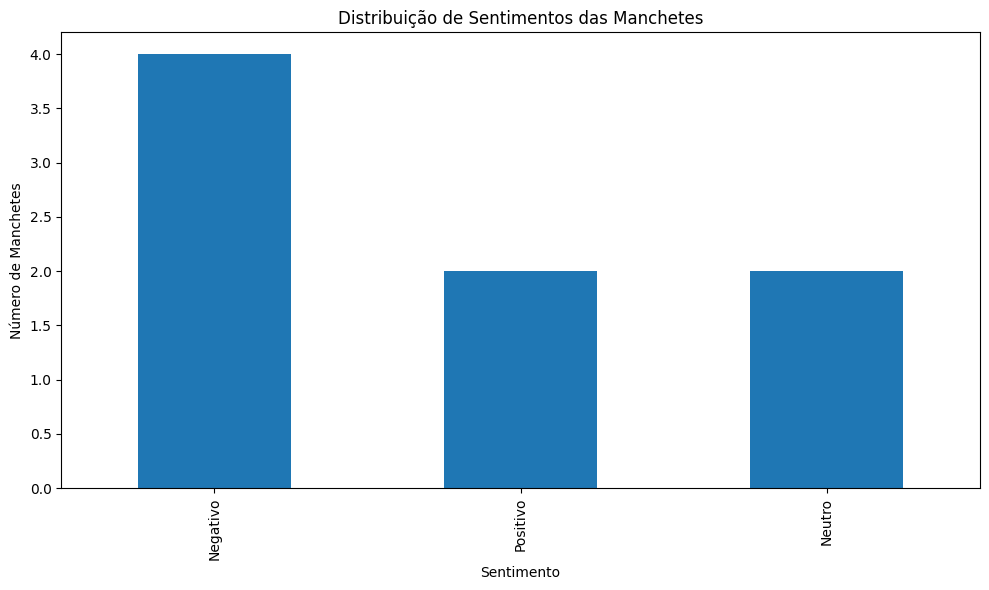

In [15]:
# Plotar distribuição de sentimentos
plot_sentiment_distribution(sentiment_results)

## Meta Prompting e Few-Shot Learning no Contexto de Análise de Sentimento

### O que é Meta Prompting?
Meta Prompting é uma técnica avançada de engenharia de prompt que envolve fornecer instruções detalhadas e contextuais para um modelo de linguagem, guiando-o para realizar uma tarefa específica de maneira mais precisa e consistente.

### Few-Shot Learning
Few-shot learning é uma abordagem onde o modelo aprende a realizar uma tarefa com apenas alguns exemplos, em vez de precisar de um grande conjunto de dados de treinamento.

### Aplicação no Nosso Exercício

#### Componentes Chave:
1. **Exemplos de Treinamento**: Fornecemos três manchetes com classificações de sentimento pré-definidas
2. **Instruções Detalhadas**: Explicamos como classificar o sentimento
3. **Formato de Resposta Estruturado**: Solicitamos uma resposta em JSON com campos específicos

#### Benefícios:
- Maior precisão na classificação de sentimento
- Flexibilidade para lidar com diferentes tipos de manchetes
- Capacidade de explicar o raciocínio por trás da classificação

### Limitações e Considerações
- A qualidade depende muito da escolha dos exemplos
- Pode haver variabilidade nas respostas
- Requer ajustes e refinamentos constantes